In [1]:
# Import Libraries
import pandas as pd
import yfinance as yf
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import GraphRicciCurvature

In [2]:
# Run the entire script --> TSX60 for Canada, S&P100 for USA

<h2> The file is in the following structure </h2>
<h4> Section 1: </h4>
    <li> Fetching the historical data, and storing it in appropriate data structure
    <li> Finding daily log returns and T=22 days Volatility
    <li> Plotting graph of T=22 days volatility
<hr>
<h4> Section 2: </h4>
    <li> Finding T=22 days rolling window Correlation of daily log returns between all possible pairs of stock
    <li> Structuring the data in appropriate format such that there are a cohort of correlation value for each day
<hr>
<h4> Section 3: </h4>
    <li> This section presents the example of just one cohort, how the things will be calculated for each cohort
    <li> It shows - Complete Correlation Graph, High Correlation Graph, Minimum Spanning Tree
    <li> Average Forman Ricci Curvature is calculated for Complete Correlation Graph and MST Graph
<hr>
<h4> Section 4: </h4>
    <li> Implementing for entire time frame what is done in Section 3 for just 1 day
<hr>
<h4> Section 5: </h4>
    <li> Results

# SECTION 1:

In [3]:
# Read the NIFTY50 Index description
nifty_stocks = pd.read_excel("NIFTY_50_DATA.xlsx")
nifty_stocks=nifty_stocks.reset_index()
nifty_stocks=nifty_stocks.rename(columns={"index":"RANK"})
nifty_stocks["RANK"]=nifty_stocks["RANK"]+1
nifty_stocks

RANK                      COMPANY      SYMBOL  WEIGHT  \
0      1                    HDFC Bank    HDFCBANK  0.1377   
1      2          Reliance Industries    RELIANCE  0.0956   
2      3                   ICICI Bank   ICICIBANK  0.0787   
3      4                      Infosys        INFY  0.0601   
4      5                          ITC         ITC  0.0455   
5      6    Tata Consultancy Services         TCS  0.0404   
6      7          Larsen & Toubro Ltd          LT  0.0384   
7      8                    Axis Bank    AXISBANK  0.0313   
8      9          Kotak Mahindra Bank   KOTAKBANK  0.0304   
9     10           Hindustan Unilever  HINDUNILVR  0.0293   
10    11          State Bank of India        SBIN  0.0277   
11    12                Bharti Airtel  BHARTIARTL  2.5600   
12    13                Bajaj Finance  BAJFINANCE  0.0229   
13    14                 Asian Paints  ASIANPAINT  0.0177   
14    15          Mahindra & Mahindra         M&M  0.0145   
15    16          Maruti Suzuki India      MARUTI  0.0153   
16    17             HCL Technologies     HCLTECH  0.0149   
17    18                   Sun Pharma   SUNPHARMA  0.0130   
18    19                Titan Company       TITAN  0.0145   
19    20              LTIMindtree Ltd        LTIM  0.0123   
20    21            Adani Enterprises    ADANIENT  0.0084   
21    22                   Tata Steel   TATASTEEL  0.0105   
22    23                Bajaj Finserv  BAJAJFINSV  0.0097   
23    24             UltraTech Cement  ULTRACEMCO  0.0112   
24    25                         NTPC        NTPC  0.0102   
25    26                IndusInd Bank  INDUSINDBK  0.0103   
26    27       Power Grid Corporation   POWERGRID  0.0098   
27    28                    JSW Steel    JSWSTEEL  0.0081   
28    29                  Tata Motors  TATAMOTORS  0.0114   
29    30                 Nestle India   NESTLEIND  0.0095   
30    31          Hindalco Industries    HINDALCO  0.0073   
31    32            Grasim Industries      GRASIM  0.0078   
32    33                Tech Mahindra       TECHM  0.0086   
33    34          Adani Ports and SEZ  ADANIPORTS  0.0069   
34    35                        Cipla       CIPLA  0.0062   
35    36                        Wipro       WIPRO  0.0074   
36    37      Oil & Natural Gas Corp.        ONGC  0.0074   
37    38      HDFC Life Insurance Co.    HDFCLIFE  0.0072   
38    39       SBI Life Insurance Co.     SBILIFE  0.0068   
39    40     Dr. Reddy's Laboratories     DRREDDY  0.0067   
40    41         Britannia Industries   BRITANNIA  0.0068   
41    42                   Coal India   COALINDIA  0.0062   
42    43       Tata Consumer Products  TATACONSUM  0.0058   
43    44  Apollo Hospitals Enterprise  APOLLOHOSP  0.0057   
44    45                Eicher Motors   EICHERMOT  0.0062   
45    46          Divi's Laboratories    DIVISLAB  0.0054   
46    47                   Bajaj Auto  BAJAJ-AUTO  0.0064   
47    48                          UPL         UPL  0.0044   
48    49                Hero MotoCorp  HEROMOTOCO  0.0044   
49    50       Bharat Petroleum Corp.        BPCL  0.0043   

                    SECTOR  
0       Financial Services  
1                Oil & Gas  
2       Financial Services  
3   Information Technology  
4                     FMCG  
5   Information Technology  
6             Construction  
7       Financial Services  
8       Financial Services  
9                     FMCG  
10      Financial Services  
11       Telecommunication  
12      Financial Services  
13       Consumer Durables  
14              Automobile  
15              Automobile  
16  Information Technology  
17              Healthcare  
18       Consumer Durables  
19  Information Technology  
20         Metals & Mining  
21         Metals & Mining  
22      Financial Services  
23  Construction Materials  
24                   Power  
25      Financial Services  
26                   Power  
27         Metals & Mining  
28              Automobile  
29                    

In [4]:
print(f"Number of Unique Sectors in NIFTY50 Index: {nifty_stocks['SECTOR'].nunique()}")
print(f"\nThe distribution of Public Companies by Sectors in NIFTY50:\n{nifty_stocks['SECTOR'].value_counts()}")

Number of Unique Sectors in NIFTY50 Index: 14

The distribution of Public Companies by Sectors in NIFTY50:
Financial Services        10
Information Technology     6
Automobile                 6
FMCG                       5
Healthcare                 5
Oil & Gas                  4
Metals & Mining            4
Consumer Durables          2
Construction Materials     2
Power                      2
Construction               1
Telecommunication          1
Services                   1
Chemicals                  1
Name: SECTOR, dtype: int64


In [5]:
# This cell extracts the data of NIFTY50 companies from yahoo finance
symbols = list(nifty_stocks["SYMBOL"])
# Create a dictionary to store data for each stock as a DataFrame
stock_data_dictionary = {}

for i in symbols:
    ticker_symbol = f"{i}.NS"
    start_date = "2017-12-31"
    end_date = "2022-12-31"
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    data=data[["Open", "High", "Low", "Close", "Volume"]]
    #Calculating Daily Log Return
    data["Log_Return"]=np.log(data['Close'] / data['Close'].shift(1))
    data["Log_Return"]=data["Log_Return"]*100
    #Calculating T=22days Volatility
    data["Volatility"]=data["Log_Return"].rolling(window=252).std()*np.sqrt(22)
    data = data.round(2)
    stock_data_dictionary[i] = data
    print(f"Data for {ticker_symbol}-------------Days:{len(data)}")

[*********************100%%**********************]  1 of 1 completed
Data for HDFCBANK.NS-------------Days:1236
[*********************100%%**********************]  1 of 1 completed
Data for RELIANCE.NS-------------Days:1236
[*********************100%%**********************]  1 of 1 completed
Data for ICICIBANK.NS-------------Days:1236
[*********************100%%**********************]  1 of 1 completed
Data for INFY.NS-------------Days:1236
[*********************100%%**********************]  1 of 1 completed
Data for ITC.NS-------------Days:1236
[*********************100%%**********************]  1 of 1 completed
Data for TCS.NS-------------Days:1236
[*********************100%%**********************]  1 of 1 completed
Data for LT.NS-------------Days:1236
[*********************100%%**********************]  1 of 1 completed
Data for AXISBANK.NS-------------Days:1236
[*********************100%%**********************]  1 of 1 completed
Data for KOTAKBANK.NS-------------Days:1236
[*********

In [6]:
stock_data_dictionary

{'HDFCBANK':                Open     High      Low    Close   Volume  Log_Return  \
 Date                                                                  
 2018-01-01   936.35   940.38   925.25   927.25  3290258         NaN   
 2018-01-02   929.28   937.50   929.28   936.17  2388158        0.96   
 2018-01-03   937.50   939.12   925.60   926.33  2265644       -1.06   
 2018-01-04   926.50   932.75   926.50   929.95  1186888        0.39   
 2018-01-05   931.50   934.03   927.78   931.80  1435434        0.20   
 ...             ...      ...      ...      ...      ...         ...   
 2022-12-26  1599.50  1639.00  1590.00  1629.45  4953661        1.97   
 2022-12-27  1633.00  1635.95  1613.50  1631.10  3963386        0.10   
 2022-12-28  1623.10  1633.00  1623.10  1629.80  4345935       -0.08   
 2022-12-29  1620.10  1643.50  1611.00  1641.30  5506448        0.70   
 2022-12-30  1645.00  1645.00  1620.00  1628.15  3561320       -0.80   
 
             Volatility  
 Date                   

In [7]:
# Creating a dataframe of daily log returns of all NIFTY stocks, this is helpful in finding correlation
daily_log_returns = pd.DataFrame()

for stock_name, stock_data in stock_data_dictionary.items():
    daily_log_returns[stock_name] = stock_data['Log_Return']

daily_log_returns=daily_log_returns.dropna()
daily_log_returns

HDFCBANK  RELIANCE  ICICIBANK  INFY   ITC   TCS    LT  AXISBANK  \
Date                                                                          
2018-01-02      0.96      0.15      -0.19 -0.37 -0.59 -0.55 -0.87     -1.07   
2018-01-03     -1.06      0.40       1.70 -0.82  0.15  0.28  2.02      0.17   
2018-01-04      0.39      0.60      -0.10 -0.58  0.15  0.70  3.12     -0.10   
2018-01-05      0.20      0.32      -0.57 -0.34  0.51  1.20 -0.06      0.60   
2018-01-08     -0.16      0.57       0.40  2.35  1.02  0.93  1.76      0.39   
...              ...       ...        ...   ...   ...   ...   ...       ...   
2022-12-26      1.97      0.87       1.61  0.35  2.39  0.76  1.36      2.41   
2022-12-27      0.10      0.81       0.83  0.83 -0.43  0.20  1.57      0.38   
2022-12-28     -0.08     -0.01      -0.19 -0.31  0.37 -0.07 -0.14     -0.81   
2022-12-29      0.70     -0.05       1.01  0.49  0.28  0.36 -0.48      1.06   
2022-12-30     -0.80      0.15      -1.91 -0.62 -1.14 -0.37 -1.20     -0.09   

            KOTAKBANK  HINDUNILVR  ...  BRITANNIA  COALINDIA  TATACONSUM  \
Date                               ...                                     
2018-01-02       0.32       -0.44  ...      -1.75       1.27       -0.56   
2018-01-03      -0.31        0.87  ...       0.53       0.66        0.02   
2018-01-04       0.03        0.14  ...      -1.17       2.17        0.34   
2018-01-05       0.26        0.32  ...       0.38       0.34        0.22   
2018-01-08       0.30        0.87  ...       1.06       3.07        1.47   
...               ...         ...  ...        ...        ...         ...   
2022-12-26      -0.46       -0.14  ...       1.00       2.62       -0.48   
2022-12-27       0.40       -0.93  ...      -0.14       0.23        0.33   
2022-12-28      -0.04       -0.37  ...       0.38       0.88        0.30   
2022-12-29      -0.07       -0.60  ...      -0.86      -0.70       -0.52   
2022-12-30       0.47       -0.27  ...      -0.94       1.52       -1.19   

            APOLLOHOSP  EICHERMOT  DIVISLAB  BAJAJ-AUTO   UPL  HEROMOTOCO  \
Date                                                                        
2018-01-02       -0.89      -4.18     -1.67        0.17  2.32       -0.14   
2018-01-03       -1.30       0.50      1.70       -1.64  0.30        0.30   
2018-01-04       -1.40      -0.85      0.65        0.72  0.75       -0.44   
2018-01-05        3.07       2.31      0.10        0.47 -0.96        0.15   
2018-01-08       -1.31      -0.14      0.77       -0.13  1.30        1.12   
...                ...        ...       ...         ...   ...         ...   
2022-12-26       -0.34       1.52     -2.01        0.29  0.99        1.86   
2022-12-27       -0.86       1.27      1.40        1.08 -0.26        0.60   
2022-12-28       -1.19       0.30     -0.89       -0.11  1.00       -0.21   
2022-12-29       -1.41       2.15     -1.00       -0.50 -0.14        0.94   
2022-12-30       -1.04      -1.64      0.03        1.32 -0.89        0.61   

            BPCL  
Date              
2018-01-02 -1.75  
2018-01-03 -0.99  
2018-01-04 -0.69  
2018-01-05 -0.78  
2018-01-08  1.93  
...          ...  
2022-12-26  0.00  
2022-12-27  0.28  
2022-12-28 -0.58  
2022-12-29  0.95  
2022-12-30  1.00  

[1235 rows x 50 columns]

In [8]:
# Creating dataframe of monthly volatility of all NIFTY stocks
monthly_volatility = pd.DataFrame()

for stock_name, stock_data in stock_data_dictionary.items():
    monthly_volatility[stock_name] = stock_data['Volatility']

monthly_volatility=monthly_volatility.dropna()
monthly_volatility

HDFCBANK  RELIANCE  ICICIBANK  INFY   ITC   TCS    LT  AXISBANK  \
Date                                                                          
2019-01-09      4.82      7.84       9.18  7.13  6.06  7.52  6.57      8.93   
2019-01-10      4.81      7.84       9.18  7.13  6.06  7.52  6.56      8.93   
2019-01-11      4.80      7.84       9.17  7.13  6.08  7.55  6.56      8.93   
2019-01-14      4.80      7.84       9.18  7.16  6.08  7.57  6.54      8.94   
2019-01-15      4.81      7.89       9.18  7.23  6.09  7.61  6.54      8.93   
...              ...       ...        ...   ...   ...   ...   ...       ...   
2022-12-26      7.53      7.85       6.78  8.17  6.34  6.90  7.41      8.53   
2022-12-27      7.53      7.83       6.77  8.17  6.34  6.90  7.40      8.53   
2022-12-28      7.53      7.83       6.77  8.16  6.30  6.89  7.40      8.53   
2022-12-29      7.53      7.83       6.77  8.16  6.30  6.89  7.39      8.52   
2022-12-30      7.53      7.83       6.79  8.16  6.31  6.89  7.40      8.51   

            KOTAKBANK  HINDUNILVR  ...  BRITANNIA  COALINDIA  TATACONSUM  \
Date                               ...                                     
2019-01-09       7.40        6.31  ...       6.50       7.76        9.97   
2019-01-10       7.42        6.31  ...       6.48       7.75        9.98   
2019-01-11       7.42        6.31  ...       6.47       7.74        9.98   
2019-01-14       7.42        6.31  ...       6.46       7.72        9.98   
2019-01-15       7.42        6.32  ...       6.49       7.72        9.98   
...               ...         ...  ...        ...        ...         ...   
2022-12-26       7.38        7.26  ...       6.95      10.35        8.01   
2022-12-27       7.37        7.26  ...       6.95      10.35        8.00   
2022-12-28       7.37        7.26  ...       6.94      10.34        7.99   
2022-12-29       7.36        7.26  ...       6.94      10.34        7.98   
2022-12-30       7.34        7.26  ...       6.94      10.35        7.99   

            APOLLOHOSP  EICHERMOT  DIVISLAB  BAJAJ-AUTO    UPL  HEROMOTOCO  \
Date                                                                         
2019-01-09       10.54       9.66      9.35        7.68  10.29        7.47   
2019-01-10       10.55       9.60      9.38        7.69  10.27        7.47   
2019-01-11       10.54       9.60      9.37        7.68  10.28        7.47   
2019-01-14       10.55       9.59      9.38        7.67  10.29        7.47   
2019-01-15       10.51       9.57      9.39        7.68  10.29        7.49   
...                ...        ...       ...         ...    ...         ...   
2022-12-26        9.51       8.88      8.95        7.05   8.96        8.48   
2022-12-27        9.50       8.85      8.90        7.06   8.92        8.48   
2022-12-28        9.49       8.85      8.88        7.05   8.92        8.46   
2022-12-29        9.49       8.86      8.89        7.05   8.92        8.47   
2022-12-30        9.50       8.87      8.88        7.06   8.91        8.47   

             BPCL  
Date               
2019-01-09  13.01  
2019-01-10  13.01  
2019-01-11  13.00  
2019-01-14  13.00  
2019-01-15  13.02  
...           ...  
2022-12-26   8.01  
2022-12-27   7.98  
2022-12-28   7.98  
2022-12-29   7.97  
2022-12-30   7.97  

[984 rows x 50 columns]

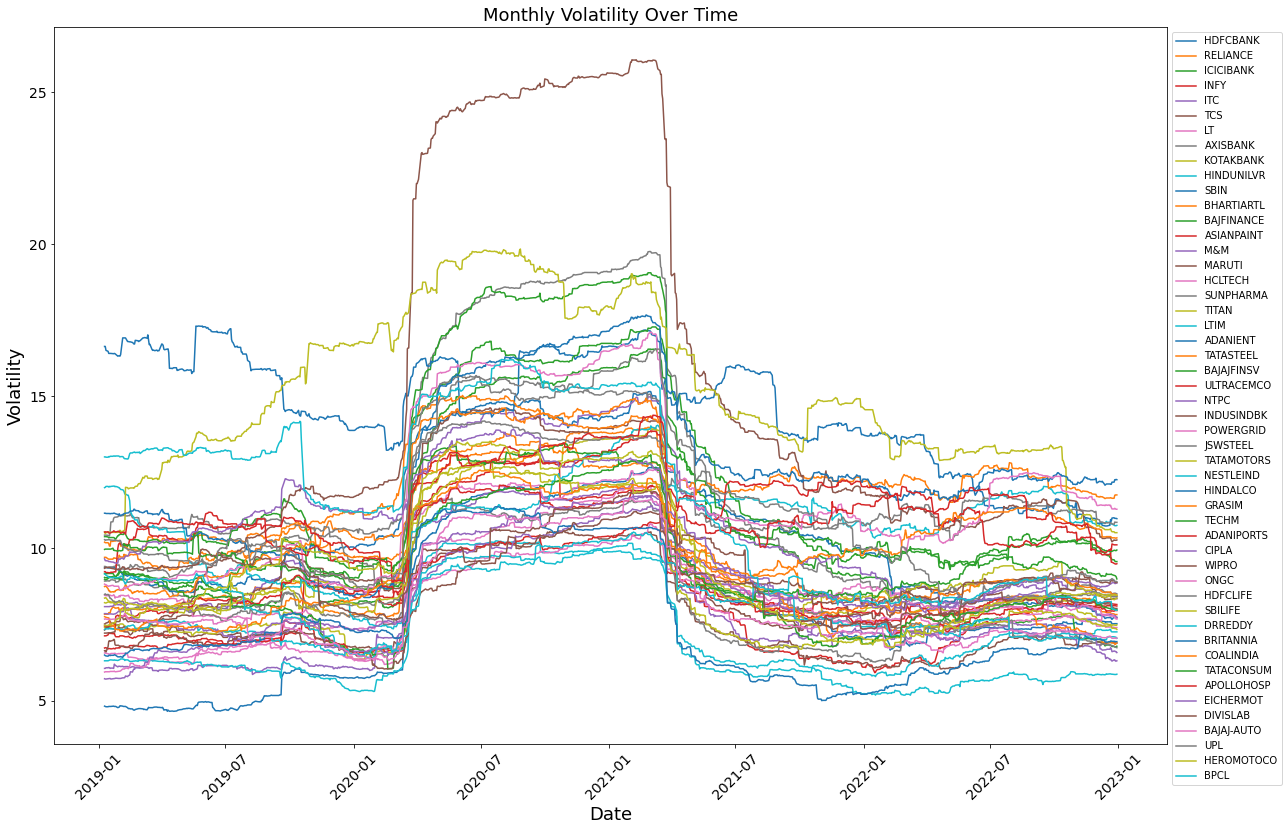

In [9]:
# Plotting monthly volatility graph with time
plt.figure(figsize=(18, 12))
ax = plt.gca()
# Plot each stock's volatility as a line plot
for column in monthly_volatility.columns:
    ax.plot(monthly_volatility.index, monthly_volatility[column], label=column)

plt.title("Monthly Volatility Over Time", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Volatility", fontsize=18)
plt.xticks(rotation=45, fontsize=14) 
plt.yticks(fontsize=14)
# Place the legend outside the plot
plt.legend(loc='best', bbox_to_anchor=(1, 1))  
plt.tight_layout()
plt.show()

# SECTION 2:

In [10]:
# Calculate Pearson correlation for each pair of stocks over 22 time period cycle that is monthly
correlation_matrix = daily_log_returns.rolling(window=22).corr(method='pearson')
correlation_matrix =correlation_matrix.dropna()
correlation_matrix

HDFCBANK  RELIANCE  ICICIBANK      INFY       ITC  \
Date                                                                       
2018-02-01 HDFCBANK    1.000000  0.038862   0.038539 -0.194089 -0.029400   
           RELIANCE    0.038862  1.000000   0.221774 -0.190356  0.004458   
           ICICIBANK   0.038539  0.221774   1.000000  0.186366 -0.059297   
           INFY       -0.194089 -0.190356   0.186366  1.000000  0.013477   
           ITC        -0.029400  0.004458  -0.059297  0.013477  1.000000   
...                         ...       ...        ...       ...       ...   
2022-12-30 DIVISLAB   -0.234157 -0.089719  -0.378837  0.099559 -0.225826   
           BAJAJ-AUTO  0.157655  0.617838   0.224646  0.256531  0.365422   
           UPL         0.427667  0.195537   0.233336  0.171152  0.282756   
           HEROMOTOCO  0.391630  0.584768   0.433826  0.201164  0.505861   
           BPCL        0.198545  0.065517   0.253986 -0.119547  0.273019   

                            TCS        LT  AXISBANK  KOTAKBANK  HINDUNILVR  \
Date                                                                         
2018-02-01 HDFCBANK    0.003803 -0.305303 -0.090477   0.595723   -0.235326   
           RELIANCE    0.102818  0.180932  0.518585   0.275148   -0.275909   
           ICICIBANK  -0.266345  0.111364  0.529904   0.033018   -0.003462   
           INFY        0.406771  0.025555  0.260873  -0.167669    0.393854   
           ITC        -0.124069  0.199348  0.176330  -0.007624   -0.238657   
...                         ...       ...       ...        ...         ...   
2022-12-30 DIVISLAB    0.318273 -0.074417 -0.434785  -0.245971   -0.069430   
           BAJAJ-AUTO  0.137047  0.234884  0.256464   0.617415    0.236248   
           UPL         0.100270  0.425348  0.218319  -0.006424   -0.003625   
           HEROMOTOCO  0.243009  0.428800  0.476205   0.231615    0.138572   
           BPCL        0.043670  0.237544  0.362391  -0.071743   -0.039686   

                       ...  BRITANNIA  COALINDIA  TATACONSUM  APOLLOHOSP  \
Date                   ...                                                 
2018-02-01 HDFCBANK    ...  -0.458722  -0.251358   -0.333655    0.148004   
           RELIANCE    ...   0.099906   0.422121    0.240158    0.238626   
           ICICIBANK   ...  -0.034018  -0.097564    0.164896   -0.154714   
           INFY        ...   0.265966  -0.094574    0.015472   -0.545492   
           ITC         ...  -0.071643   0.285748   -0.001283   -0.084246   
...                    ...        ...        ...         ...         ...   
2022-12-30 DIVISLAB    ...  -0.383455  -0.086468    0.134230    0.593177   
           BAJAJ-AUTO  ...   0.221127   0.574516    0.424173    0.080371   
           UPL         ...   0.124092   0.623243    0.439205    0.026801   
           HEROMOTOCO  ...   0.516237   0.657300    0.486802    0.114713   
           BPCL        ...   0.163406   0.282101    0.220551   -0.035931   

                       EICHERMOT  DIVISLAB  BAJAJ-AUTO       UPL  HEROMOTOCO  \
Date                                                                           
2018-02-01 HDFCBANK    -0.191387 -0.419631    0.058446  0.134127   -0.153640   
           RELIANCE    -0.109162 -0.255148    0.009198  0.034275   -0.018543   
           ICICIBANK   -0.078664  0.316587   -0.368076 -0.302258   -0.473413   
           INFY        -0.029067  0.460292    0.107976  0.274200   -0.096870   
           ITC         -0.123351  0.189907    0.168192  0.315220    0.099797   
...                          ...       ...         ...       ...         ...   
2022-12-30 DIVISLAB    -0.102618  1.000000    0.217873  0.102539    0.000224   
           BAJAJ-AUTO   0.503773  0.217873    1.000000  0.175432    0.567447   
           UPL          0.474340  0.102539    0.175432  1.000000    0.362660   
           HEROMOTOCO   0.597421  0.000224    0.567447  0.362660    1.000000   
           BPCL         0.176607 -0.003606   -0.060469  0.316998    0.

In [11]:
# Modify the matrix in a better easier to handle dataframe
temp=correlation_matrix.reset_index()
temp=temp.rename(columns={"level_1":"Base_Stock"})
temp=temp.set_index("Base_Stock")
correlation_matrix=temp
correlation_matrix

Date  HDFCBANK  RELIANCE  ICICIBANK      INFY       ITC  \
Base_Stock                                                                 
HDFCBANK   2018-02-01  1.000000  0.038862   0.038539 -0.194089 -0.029400   
RELIANCE   2018-02-01  0.038862  1.000000   0.221774 -0.190356  0.004458   
ICICIBANK  2018-02-01  0.038539  0.221774   1.000000  0.186366 -0.059297   
INFY       2018-02-01 -0.194089 -0.190356   0.186366  1.000000  0.013477   
ITC        2018-02-01 -0.029400  0.004458  -0.059297  0.013477  1.000000   
...               ...       ...       ...        ...       ...       ...   
DIVISLAB   2022-12-30 -0.234157 -0.089719  -0.378837  0.099559 -0.225826   
BAJAJ-AUTO 2022-12-30  0.157655  0.617838   0.224646  0.256531  0.365422   
UPL        2022-12-30  0.427667  0.195537   0.233336  0.171152  0.282756   
HEROMOTOCO 2022-12-30  0.391630  0.584768   0.433826  0.201164  0.505861   
BPCL       2022-12-30  0.198545  0.065517   0.253986 -0.119547  0.273019   

                 TCS        LT  AXISBANK  KOTAKBANK  ...  BRITANNIA  \
Base_Stock                                           ...              
HDFCBANK    0.003803 -0.305303 -0.090477   0.595723  ...  -0.458722   
RELIANCE    0.102818  0.180932  0.518585   0.275148  ...   0.099906   
ICICIBANK  -0.266345  0.111364  0.529904   0.033018  ...  -0.034018   
INFY        0.406771  0.025555  0.260873  -0.167669  ...   0.265966   
ITC        -0.124069  0.199348  0.176330  -0.007624  ...  -0.071643   
...              ...       ...       ...        ...  ...        ...   
DIVISLAB    0.318273 -0.074417 -0.434785  -0.245971  ...  -0.383455   
BAJAJ-AUTO  0.137047  0.234884  0.256464   0.617415  ...   0.221127   
UPL         0.100270  0.425348  0.218319  -0.006424  ...   0.124092   
HEROMOTOCO  0.243009  0.428800  0.476205   0.231615  ...   0.516237   
BPCL        0.043670  0.237544  0.362391  -0.071743  ...   0.163406   

            COALINDIA  TATACONSUM  APOLLOHOSP  EICHERMOT  DIVISLAB  \
Base_Stock                                                           
HDFCBANK    -0.251358   -0.333655    0.148004  -0.191387 -0.419631   
RELIANCE     0.422121    0.240158    0.238626  -0.109162 -0.255148   
ICICIBANK   -0.097564    0.164896   -0.154714  -0.078664  0.316587   
INFY        -0.094574    0.015472   -0.545492  -0.029067  0.460292   
ITC          0.285748   -0.001283   -0.084246  -0.123351  0.189907   
...               ...         ...         ...        ...       ...   
DIVISLAB    -0.086468    0.134230    0.593177  -0.102618  1.000000   
BAJAJ-AUTO   0.574516    0.424173    0.080371   0.503773  0.217873   
UPL          0.623243    0.439205    0.026801   0.474340  0.102539   
HEROMOTOCO   0.657300    0.486802    0.114713   0.597421  0.000224   
BPCL         0.282101    0.220551   -0.035931   0.176607 -0.003606   

            BAJAJ-AUTO       UPL  HEROMOTOCO      BPCL  
Base_Stock                                              
HDFCBANK      0.058446  0.134127   -0.153640 -0.391296  
RELIANCE      0.009198  0.034275   -0.018543  0.018018  
ICICIBANK    -0.368076 -0.302258   -0.473413  0.114145  
INFY          0.107976  0.274200   -0.096870 -0.062708  
ITC           0.168192  0.315220    0.099797  0.173263  
...                ...       ...         ...       ...  
DIVISLAB      0.217873  0.102539    0.000224 -0.003606  
BAJAJ-AUTO    1.000000  0.175432    0.567447 -0.060469  
UPL           0.175432  1.000000    0.362660  0.316998  
HEROMOTOCO    0.567447  0.362660    1.000000  0.311980  
BPCL         -0.060469  0.316998    0.311980  1.000000  

[60700 rows x 51 columns]

In [12]:
# Groupby Correlation matrix with Date so that for each day we have some prevailing value of correlation
grouped_data=correlation_matrix.groupby("Date")
num_groups = grouped_data.ngroups
print(f"Number of Cohort of Correlations: {num_groups}")

Number of Cohort of Correlations: 1214


**For each group (cohort) there will a network of correlation graph. From these network of graph we find**
- Correlation Network, considering all correlation values
- Strong Correlation Network, considering only strong correlation values
- Minimum Spanning Treee (MST) of the Correlation Network
- Ricci curvature (Average value Ricci Curvature from Minimum Spanning Tree network)
- Structural Entropy

# SECTION 3: Example of just one cohort

In [13]:
# Latest Group of T=22days Correlation data
df=grouped_data.get_group('2018-02-01')
df=df.reset_index()
df

Base_Stock       Date  HDFCBANK  RELIANCE  ICICIBANK      INFY       ITC  \
0     HDFCBANK 2018-02-01  1.000000  0.038862   0.038539 -0.194089 -0.029400   
1     RELIANCE 2018-02-01  0.038862  1.000000   0.221774 -0.190356  0.004458   
2    ICICIBANK 2018-02-01  0.038539  0.221774   1.000000  0.186366 -0.059297   
3         INFY 2018-02-01 -0.194089 -0.190356   0.186366  1.000000  0.013477   
4          ITC 2018-02-01 -0.029400  0.004458  -0.059297  0.013477  1.000000   
5          TCS 2018-02-01  0.003803  0.102818  -0.266345  0.406771 -0.124069   
6           LT 2018-02-01 -0.305303  0.180932   0.111364  0.025555  0.199348   
7     AXISBANK 2018-02-01 -0.090477  0.518585   0.529904  0.260873  0.176330   
8    KOTAKBANK 2018-02-01  0.595723  0.275148   0.033018 -0.167669 -0.007624   
9   HINDUNILVR 2018-02-01 -0.235326 -0.275909  -0.003462  0.393854 -0.238657   
10        SBIN 2018-02-01 -0.238742  0.121295   0.070949  0.235646  0.306029   
11  BHARTIARTL 2018-02-01 -0.155413  0.168013   0.258683 -0.180675 -0.047157   
12  BAJFINANCE 2018-02-01 -0.271258  0.186765  -0.308436 -0.207638  0.256855   
13  ASIANPAINT 2018-02-01  0.026366  0.083616   0.069377 -0.202544  0.171838   
14         M&M 2018-02-01 -0.091857 -0.084909  -0.152565 -0.237197  0.338940   
15      MARUTI 2018-02-01  0.151235  0.062938  -0.117758  0.271663 -0.173245   
16     HCLTECH 2018-02-01 -0.261260 -0.202674   0.012515  0.607265 -0.163500   
17   SUNPHARMA 2018-02-01 -0.028133  0.130406  -0.036650  0.451678 -0.100835   
18       TITAN 2018-02-01  0.172215  0.612028   0.247883 -0.125708  0.024635   
19        LTIM 2018-02-01 -0.131436 -0.081732  -0.088740  0.103405  0.115489   
20    ADANIENT 2018-02-01 -0.534190  0.182298   0.199444 -0.092831  0.079210   
21   TATASTEEL 2018-02-01 -0.133701  0.294768   0.344004  0.107796  0.026185   
22  BAJAJFINSV 2018-02-01 -0.320666 -0.001912  -0.357099 -0.000019  0.290629   
23  ULTRACEMCO 2018-02-01 -0.215319  0.173189   0.298621  0.058217 -0.398417   
24        NTPC 2018-02-01  0.037030 -0.003125   0.003979  0.198689 -0.024377   
25  INDUSINDBK 2018-02-01 -0.068577  0.136080  -0.154515 -0.263139  0.237365   
26   POWERGRID 2018-02-01 -0.037749  0.019316   0.071626 -0.239391  0.420003   
27    JSWSTEEL 2018-02-01 -0.494557  0.121088   0.213481 -0.050491  0.098508   
28  TATAMOTORS 2018-02-01  0.115666  0.567771   0.042182 -0.179525 -0.143284   
29   NESTLEIND 2018-02-01  0.159765  0.012850  -0.069474  0.332526 -0.354239   
30    HINDALCO 2018-02-01 -0.417618  0.379286   0.449645 -0.079762 -0.115912   
31      GRASIM 2018-02-01 -0.059103  0.245385  -0.125066 -0.125938  0.138330   
32       TECHM 2018-02-01 -0.214799  0.139624  -0.269034  0.423921 -0.268149   
33  ADANIPORTS 2018-02-01 -0.394882  0.160213  -0.045542  0.105385 -0.058687   
34       CIPLA 2018-02-01 -0.260041  0.334892   0.451230  0.246769  0.357123   
35       WIPRO 2018-02-01  0.166616 -0.331901  -0.060273  0.309507 -0.278634   
36        ONGC 2018-02-01 -0.019613  0.444172  -0.000882  0.193876 -0.100118   
37    HDFCLIFE 2018-02-01  0.182774 -0.141012  -0.065080  0.127050  0.129512   
38     SBILIFE 2018-02-01 -0.196644  0.082778  -0.049691 -0.114898  0.396194   
39     DRREDDY 2018-02-01 -0.099903  0.100643   0.176246  0.334123  0.251709   
40   BRITANNIA 2018-02-01 -0.458722  0.099906  -0.034018  0.265966 -0.071643   
41   COALINDIA 2018-02-01 -0.251358  0.422121  -0.097564 -0.094574  0.285748   
42  TATACONSUM 2018-02-01 -0.333655  0.240158   0.164896  0.015472 -0.001283   
43  APOLLOHOSP 2018-02-01  0.148004  0.238626  -0.154714 -0.545492 -0.084246   
44   EICHERMOT 2018-02-01 -0.191387 -0.109162  -0.078664 -0.029067 -0.123351   
45    DIVISLAB 2018-02-01 -0.419631 -0.255148   0.316587  0.460292  0.189907   
46  BAJAJ-AUTO 2018-02-01  0.058446  0.009198  -0.368076  0.107976  0.168192   
47         UPL 2018-02-01  0.134127  0.034275  -0.302258  0.274200  0.315220   
48  HEROMOTOCO 2018-02-01 -0.153640 -0.018543  -0.473413 -0.096870  0.099797   
49  

In [14]:
melted_df = pd.melt(df, id_vars=['Date', 'Base_Stock'], value_name='Correlation')
melted_df = melted_df.rename(columns={"variable":"Cross_Stock"})
melted_df = melted_df[~(melted_df["Base_Stock"]==melted_df["Cross_Stock"])]
# Only one pair for A-B and B-A should occur
melted_df=melted_df[melted_df["Base_Stock"]<melted_df["Cross_Stock"]]
melted_df=melted_df.sort_values(by="Base_Stock")
melted_df=melted_df.reset_index(drop=True)
melted_df

Date  Base_Stock Cross_Stock  Correlation
0    2018-02-01    ADANIENT        SBIN     0.206428
1    2018-02-01    ADANIENT    DIVISLAB     0.572587
2    2018-02-01    ADANIENT    RELIANCE     0.182298
3    2018-02-01    ADANIENT     DRREDDY     0.157507
4    2018-02-01    ADANIENT     HCLTECH    -0.063407
...         ...         ...         ...          ...
1220 2018-02-01       TITAN  ULTRACEMCO     0.340286
1221 2018-02-01       TITAN       WIPRO    -0.219810
1222 2018-02-01  ULTRACEMCO         UPL    -0.363011
1223 2018-02-01  ULTRACEMCO       WIPRO    -0.207008
1224 2018-02-01         UPL       WIPRO    -0.050546

[1225 rows x 4 columns]

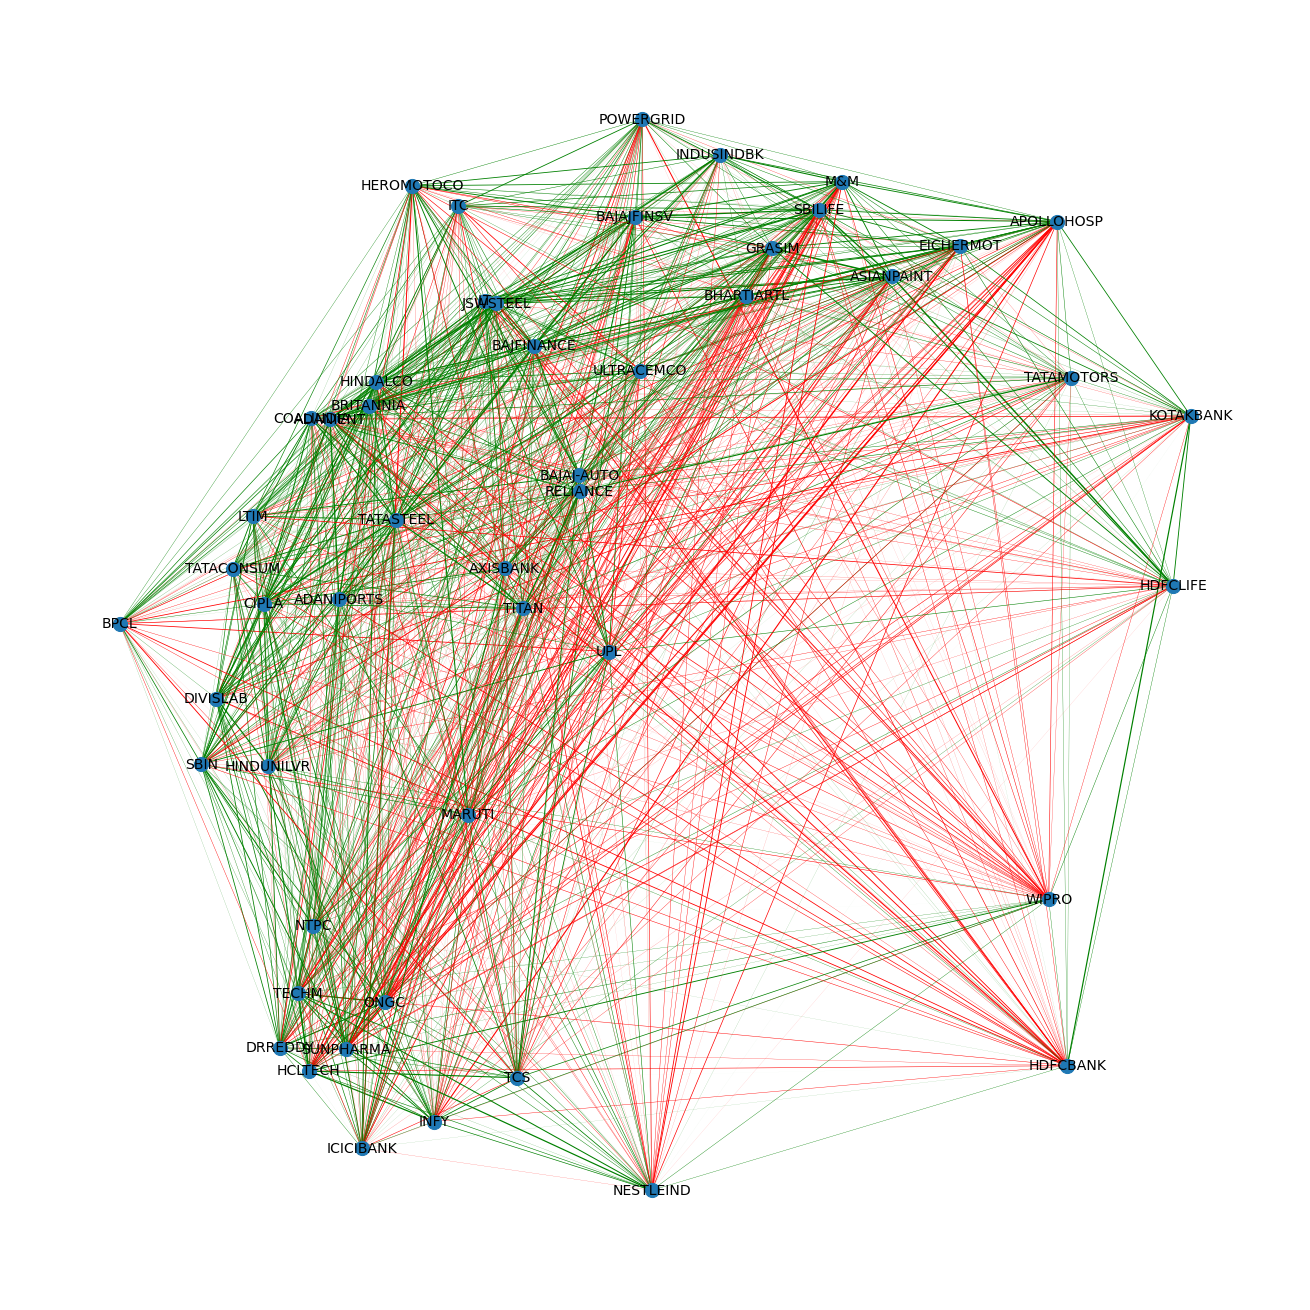

Sum of Value of Correlation:  108.06


In [15]:
# Correlation graph of all possible Correlations

G1 = nx.Graph()
# Add nodes (stock names)
stocks=list(set(list(melted_df["Base_Stock"].unique())+list(melted_df["Cross_Stock"].unique())))
nodes = stocks
G1.add_nodes_from(nodes)

# Add edges with correlation values as edge weights
for index, row in melted_df.iterrows():
    base=row["Base_Stock"]
    cross=row["Cross_Stock"]
    correlation=row["Correlation"]
    
    # Determine edge color and thickness
    if correlation > 0:
        edge_color = 'green'
    else:
        edge_color = 'red'
    
    edge_width = abs(correlation) * 2 # thickness multiplier
    G1.add_edge(base, cross, weight=correlation, color=edge_color, width=edge_width)
    
# Extract edge attributes
edge_colors = [data["color"] for u, v, data in G1.edges(data=True)]
edge_widths = [data["width"] for u, v, data in G1.edges(data=True)]

# Visualize the graph
plt.figure(figsize=(18, 18))
pos = nx.spring_layout(G1) 
nx.draw(G1, pos, with_labels=True, node_size=200, font_size=14, font_color="black", edge_color=edge_colors, width=edge_widths)
plt.show()

sum_correlation = round((melted_df['Correlation'].sum()), 2)
print("Sum of Value of Correlation: ", sum_correlation)

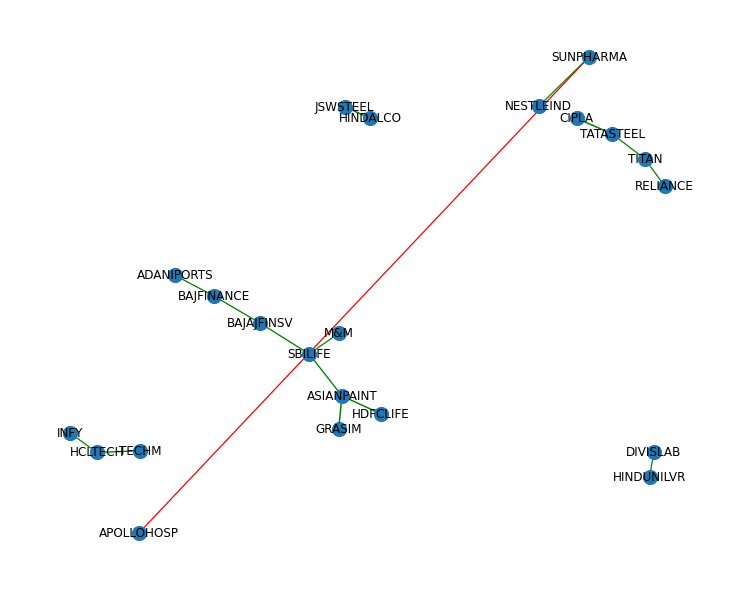

Number of Nodes in High Correlation Graph:  22
Number of Edges in High Correlation Graph:  16
Average Degree in High Correlation Graph: 1.45


In [16]:
# Graph made by considering only high correlation values whether positive or negative

high_corr_df = melted_df[(melted_df["Correlation"]>.60)|(melted_df["Correlation"]<-.60)]
high_corr_df = high_corr_df.reset_index(drop=True)

# Create a graph
G2 = nx.Graph()

# Add nodes (stock names)
stocks=list(set(list(high_corr_df["Base_Stock"].unique())+list(high_corr_df["Cross_Stock"].unique())))
nodes = stocks
G2.add_nodes_from(nodes)

# Add edges with correlation values as edge weights
for index, row in high_corr_df.iterrows():
    base=row["Base_Stock"]
    cross=row["Cross_Stock"]
    correlation=row["Correlation"]
    G2.add_edge(base, cross, weight=correlation)
    
    # Determine edge color and thickness
    if correlation > 0:
        edge_color = 'green'
    else:
        edge_color = 'red'
    
    edge_width = abs(correlation) * 2  # thickness multiplier
    G2.add_edge(base, cross, weight=correlation, color=edge_color, width=edge_width)
    
# Extract edge attributes
edge_colors = [data["color"] for u, v, data in G2.edges(data=True)]
edge_widths = [data["width"] for u, v, data in G2.edges(data=True)]

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G2)  
nx.draw(G2, pos, with_labels=True, node_size=200, font_size=12, font_color="black", edge_color=edge_colors, width=edge_widths)
plt.show()

nodes = len(G2.nodes())
edges = len(G2.edges())
# Calculate the average degree of the graph
degrees=dict(G2.degree())
average_degree = round((sum(degrees.values()) / len(degrees)),2)
print("Number of Nodes in High Correlation Graph: ", nodes)
print("Number of Edges in High Correlation Graph: ", edges)
print("Average Degree in High Correlation Graph:", average_degree)

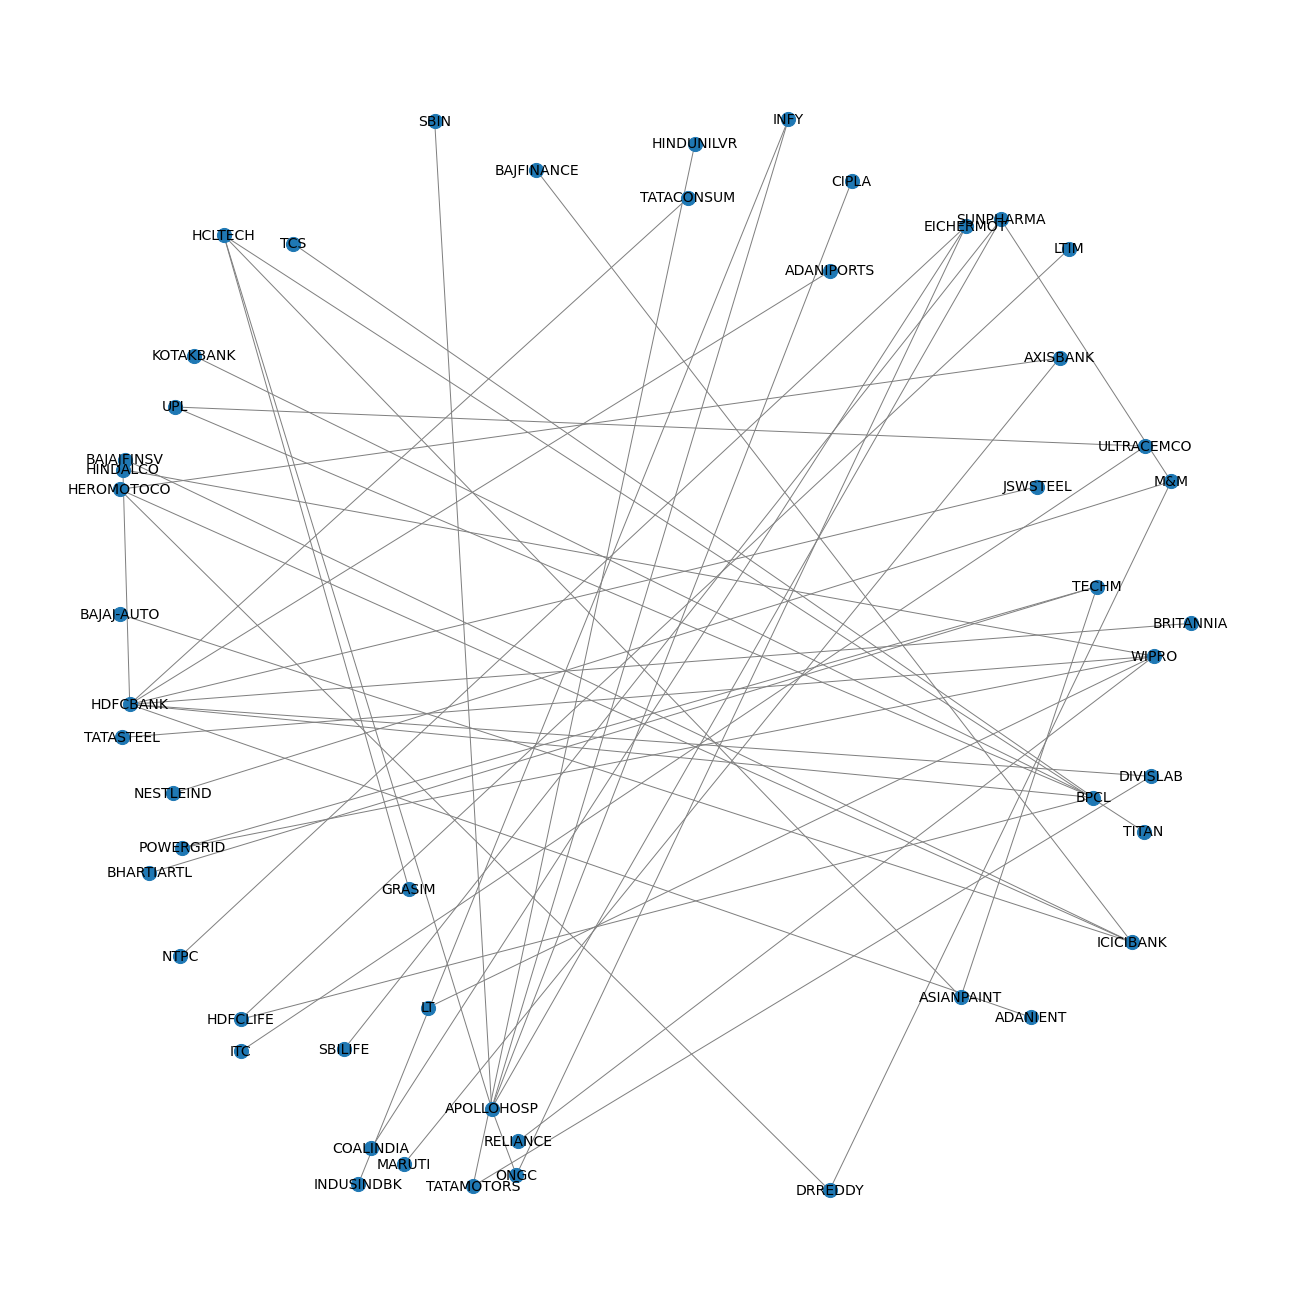

Cost Function (Sum of edge weights in MST): -19.1
Number of Communities Detected in MST: 7


In [17]:
# Calculate Minimum Spanning Tree
mst = nx.minimum_spanning_tree(G1)
# Create a graph with only MST edges
mst_graph = G1.edge_subgraph(mst.edges)

# Draw the graph with only MST edges
plt.figure(figsize=(18, 18))
pos = nx.spring_layout(mst)
nx.draw(mst_graph, pos, with_labels=True, node_size=200, font_size=14, font_color="black", edge_color='grey')
plt.show()

# Calculate and print the cost function
cost = round((sum([data['weight'] for u, v, data in mst.edges(data=True)])), 2)
print("Cost Function (Sum of edge weights in MST):", cost)

c = nx.community.greedy_modularity_communities(mst)
print(f"Number of Communities Detected in MST: {len(c)}")

In [18]:
# Finding Ricci Curvature of Discrete Network Graph

# Dependencies required for calculating Ricci Curvature
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
import community.community_louvain as community_louvain

In [19]:
# Create a mapping dictionary from SYMBOL to RANK
# Ricci Curvature algorithm needs nodes to be in integer and not string
symbol_to_rank = dict(zip(nifty_stocks["SYMBOL"], nifty_stocks["RANK"]))

In [20]:
# Relabel nodes in G1 using the mapping dictionary
relabel_dict = {node: symbol_to_rank.get(node, node) for node in G1.nodes()}
G = nx.relabel_nodes(G1, relabel_dict, copy=True)

frc = FormanRicci(G)
frc.compute_ricci_curvature()
s=0
c=0
for n1,n2 in list(G.edges()):
    s=s+frc.G[n1][n2]["formanCurvature"]
    c=c+1

avg_forman1 = round((s/c), 2)
print(f"Average Value of Forman Ricci Curvature of Complete Correlation Graph: {avg_forman1}")

Average Value of Forman Ricci Curvature of Complete Correlation Graph: 5.2


In [21]:
# Relabel nodes in G1 using the mapping dictionary
relabel_dict = {node: symbol_to_rank.get(node, node) for node in mst.nodes()}
G = nx.relabel_nodes(mst, relabel_dict, copy=True)

frc = FormanRicci(G)
frc.compute_ricci_curvature()
s=0
c=0
for n1,n2 in list(G.edges()):
    s=s+frc.G[n1][n2]["formanCurvature"]
    c=c+1

avg_forman2 = round((s/c), 2)
print(f"Average Value of Forman Ricci Curvature of MST Correlation Graph: {avg_forman2}")

Average Value of Forman Ricci Curvature of MST Correlation Graph: 6.22


# SECTION 4: Implementing for entire time period

In [22]:
resultant_df = pd.DataFrame()
for i in list(grouped_data.groups.keys()):
    temp_dict = {}
    print(f"Finding data for cohort: {i.strftime('%Y-%m-%d')}")    
    temp_dict["Date"]=i
    df=grouped_data.get_group(i)
    df=df.reset_index()
    melted_df = pd.melt(df, id_vars=['Date', 'Base_Stock'], value_name='Correlation')
    melted_df = melted_df.rename(columns={"variable":"Cross_Stock"})
    melted_df = melted_df[~(melted_df["Base_Stock"]==melted_df["Cross_Stock"])]
    # Only one pair for A-B and B-A should occur
    melted_df=melted_df[melted_df["Base_Stock"]<melted_df["Cross_Stock"]]
    melted_df=melted_df.sort_values(by="Base_Stock")
    melted_df=melted_df.reset_index(drop=True)
    #---------------------------------------------------------------------------------------------------------------
    # Create Complete Correlation graph
    G1 = nx.Graph()
    # Add nodes (stock names)
    stocks=list(set(list(melted_df["Base_Stock"].unique())+list(melted_df["Cross_Stock"].unique())))
    nodes = stocks
    G1.add_nodes_from(nodes)
    # Add edges with correlation values as edge weights
    for index, row in melted_df.iterrows():
        base=row["Base_Stock"]
        cross=row["Cross_Stock"]
        correlation=row["Correlation"]
        # Determine edge color and thickness
        if correlation > 0:
            edge_color = 'green'
        else:
            edge_color = 'red'
        edge_width = abs(correlation) * 2 # thickness multiplier
        G1.add_edge(base, cross, weight=correlation, color=edge_color, width=edge_width)
    sum_correlation = round((melted_df['Correlation'].sum()), 2)
    #print("Sum of Value of Correlation: ", sum_correlation)
    temp_dict["Sum_Correlation"]=sum_correlation
    #---------------------------------------------------------------------------------------------------------------
    high_corr_df = melted_df[(melted_df["Correlation"]>.60)|(melted_df["Correlation"]<-.60)]
    high_corr_df = high_corr_df.reset_index(drop=True)
    # Create High Correlation graph
    G2 = nx.Graph()
    # Add nodes (stock names)
    stocks=list(set(list(high_corr_df["Base_Stock"].unique())+list(high_corr_df["Cross_Stock"].unique())))
    nodes = stocks
    G2.add_nodes_from(nodes)
    # Add edges with correlation values as edge weights
    for index, row in high_corr_df.iterrows():
        base=row["Base_Stock"]
        cross=row["Cross_Stock"]
        correlation=row["Correlation"]
        G2.add_edge(base, cross, weight=correlation)
        # Determine edge color and thickness
        if correlation > 0:
            edge_color = 'green'
        else:
            edge_color = 'red'
        edge_width = abs(correlation) * 2  # thickness multiplier
        G2.add_edge(base, cross, weight=correlation, color=edge_color, width=edge_width)
    nodes = len(G2.nodes())
    edges = len(G2.edges())
    # Calculate the average degree of the graph
    degrees=dict(G2.degree())
    average_degree = round((sum(degrees.values()) / len(degrees)),2)
    #print("Number of Nodes in High Correlation Graph: ", nodes)
    #print("Number of Edges in High Correlation Graph: ", edges)
    #print("Average Degree in High Correlation Graph:", average_degree)
    temp_dict["Nodes_High_Corr"]=nodes
    temp_dict["Edges_High_Corr"]=edges
    temp_dict["AverageDegree_High_Corr"]=average_degree
    #---------------------------------------------------------------------------------------------------------------
    # Calculate Minimum Spanning Tree
    mst = nx.minimum_spanning_tree(G1)
    # Create a graph with only MST edges
    mst_graph = G1.edge_subgraph(mst.edges)
    # Calculate and print the cost function
    cost = round((sum([data['weight'] for u, v, data in mst.edges(data=True)])), 2)
    #print("Cost Function (Sum of edge weights in MST):", cost)
    community = nx.community.greedy_modularity_communities(mst)
    #print(f"Number of Communities Detected in MST: {len(community)}")
    temp_dict["Weight_of_MST"]=cost
    temp_dict["Community_in_MST"]=community
    #---------------------------------------------------------------------------------------------------------------
    # Relabel nodes in G1 using the mapping dictionary and finding curvature
    relabel_dict = {node: symbol_to_rank.get(node, node) for node in G1.nodes()}
    G = nx.relabel_nodes(G1, relabel_dict, copy=True)
    frc = FormanRicci(G)
    frc.compute_ricci_curvature()
    s=0
    c=0
    for n1,n2 in list(G.edges()):
        s=s+frc.G[n1][n2]["formanCurvature"]
        c=c+1
    avg_forman1 = round((s/c), 2)
    #print(f"Average Value of Forman Ricci Curvature of Complete Correlation Graph: {avg_forman1}")
    temp_dict["Curvature"]=avg_forman1
    #---------------------------------------------------------------------------------------------------------------
    new = pd.DataFrame.from_dict(temp_dict) 
    resultant_df=pd.concat([resultant_df,new], axis=0)
    print("---------------------------------------------------------------------------------------------------------------")

Finding data for cohort: 2018-02-01
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-02-02
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-02-05
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-02-06
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-02-07
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-02-08
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-02-09
----------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-04-30
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-05-02
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-05-03
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-05-04
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-05-07
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-05-08
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-07-19
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-07-20
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-07-23
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-07-24
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-07-25
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-07-26
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-10-12
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-10-15
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-10-16
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-10-17
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-10-19
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2018-10-22
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-01-07
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-01-08
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-01-09
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-01-10
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-01-11
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-01-14
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-04-02
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-04-03
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-04-04
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-04-05
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-04-08
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-04-09
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-06-27
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-06-28
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-07-01
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-07-02
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-07-03
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-07-04
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-09-23
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-09-24
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-09-25
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-09-26
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-09-27
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-09-30
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-12-17
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-12-18
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-12-19
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-12-20
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-12-23
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2019-12-24
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-03-06
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-03-09
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-03-11
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-03-12
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-03-13
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-03-16
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-06-03
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-06-04
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-06-05
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-06-08
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-06-09
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-06-10
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-08-21
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-08-24
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-08-25
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-08-26
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-08-27
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-08-28
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-11-10
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-11-11
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-11-12
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-11-13
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-11-14
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2020-11-17
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-02-03
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-02-04
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-02-05
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-02-08
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-02-09
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-02-10
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-04-29
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-04-30
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-05-03
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-05-04
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-05-05
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-05-06
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-07-19
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-07-20
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-07-22
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-07-23
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-07-26
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-07-27
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-10-11
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-10-12
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-10-13
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-10-14
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-10-18
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2021-10-19
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-01-03
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-01-04
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-01-05
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-01-06
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-01-07
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-01-10
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-03-29
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-03-30
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-03-31
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-04-01
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-04-04
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-04-05
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-06-21
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-06-22
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-06-23
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-06-24
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-06-27
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-06-28
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-09-12
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-09-13
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-09-14
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-09-15
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-09-16
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-09-19
---------------------------------------------------------------------------------------------------------------


---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-12-06
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-12-07
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-12-08
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-12-09
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-12-12
---------------------------------------------------------------------------------------------------------------
Finding data for cohort: 2022-12-13
---------------------------------------------------------------------------------------------------------------


In [23]:
temp=resultant_df["Date"].value_counts().to_frame()
temp=temp.rename(columns={"Date":"Community_in_MST"})
temp=temp.reset_index().rename(columns={"index":"Date"})
resultant_df=resultant_df.drop(columns="Community_in_MST")
resultant_df=resultant_df.drop_duplicates(keep='first')
resultant_df=resultant_df.merge(temp, on="Date")
resultant_df

Date  Sum_Correlation  Nodes_High_Corr  Edges_High_Corr  \
0    2018-02-01           108.06               22               16   
1    2018-02-02           214.47               36               38   
2    2018-02-05           211.48               34               36   
3    2018-02-06           245.16               36               36   
4    2018-02-07           232.56               37               35   
...         ...              ...              ...              ...   
1209 2022-12-26           377.55               43              149   
1210 2022-12-27           385.37               43              159   
1211 2022-12-28           389.54               45              151   
1212 2022-12-29           389.25               45              164   
1213 2022-12-30           358.25               43              148   

      AverageDegree_High_Corr  Weight_of_MST  Curvature  Community_in_MST  
0                        1.45         -19.10       5.20                 7  
1                        2.11         -15.01       6.23                 7  
2                        2.12         -14.95       6.18                 7  
3                        2.00         -13.53       6.42                 6  
4                        1.89         -13.71       6.29                 6  
...                       ...            ...        ...               ...  
1209                     6.93          -9.66       9.50                 8  
1210                     7.40          -9.73       9.70                 6  
1211                     6.71          -9.91       9.88                 6  
1212                     7.29         -10.87       9.98                 6  
1213                     6.88         -12.68       9.33                 7  

[1214 rows x 8 columns]

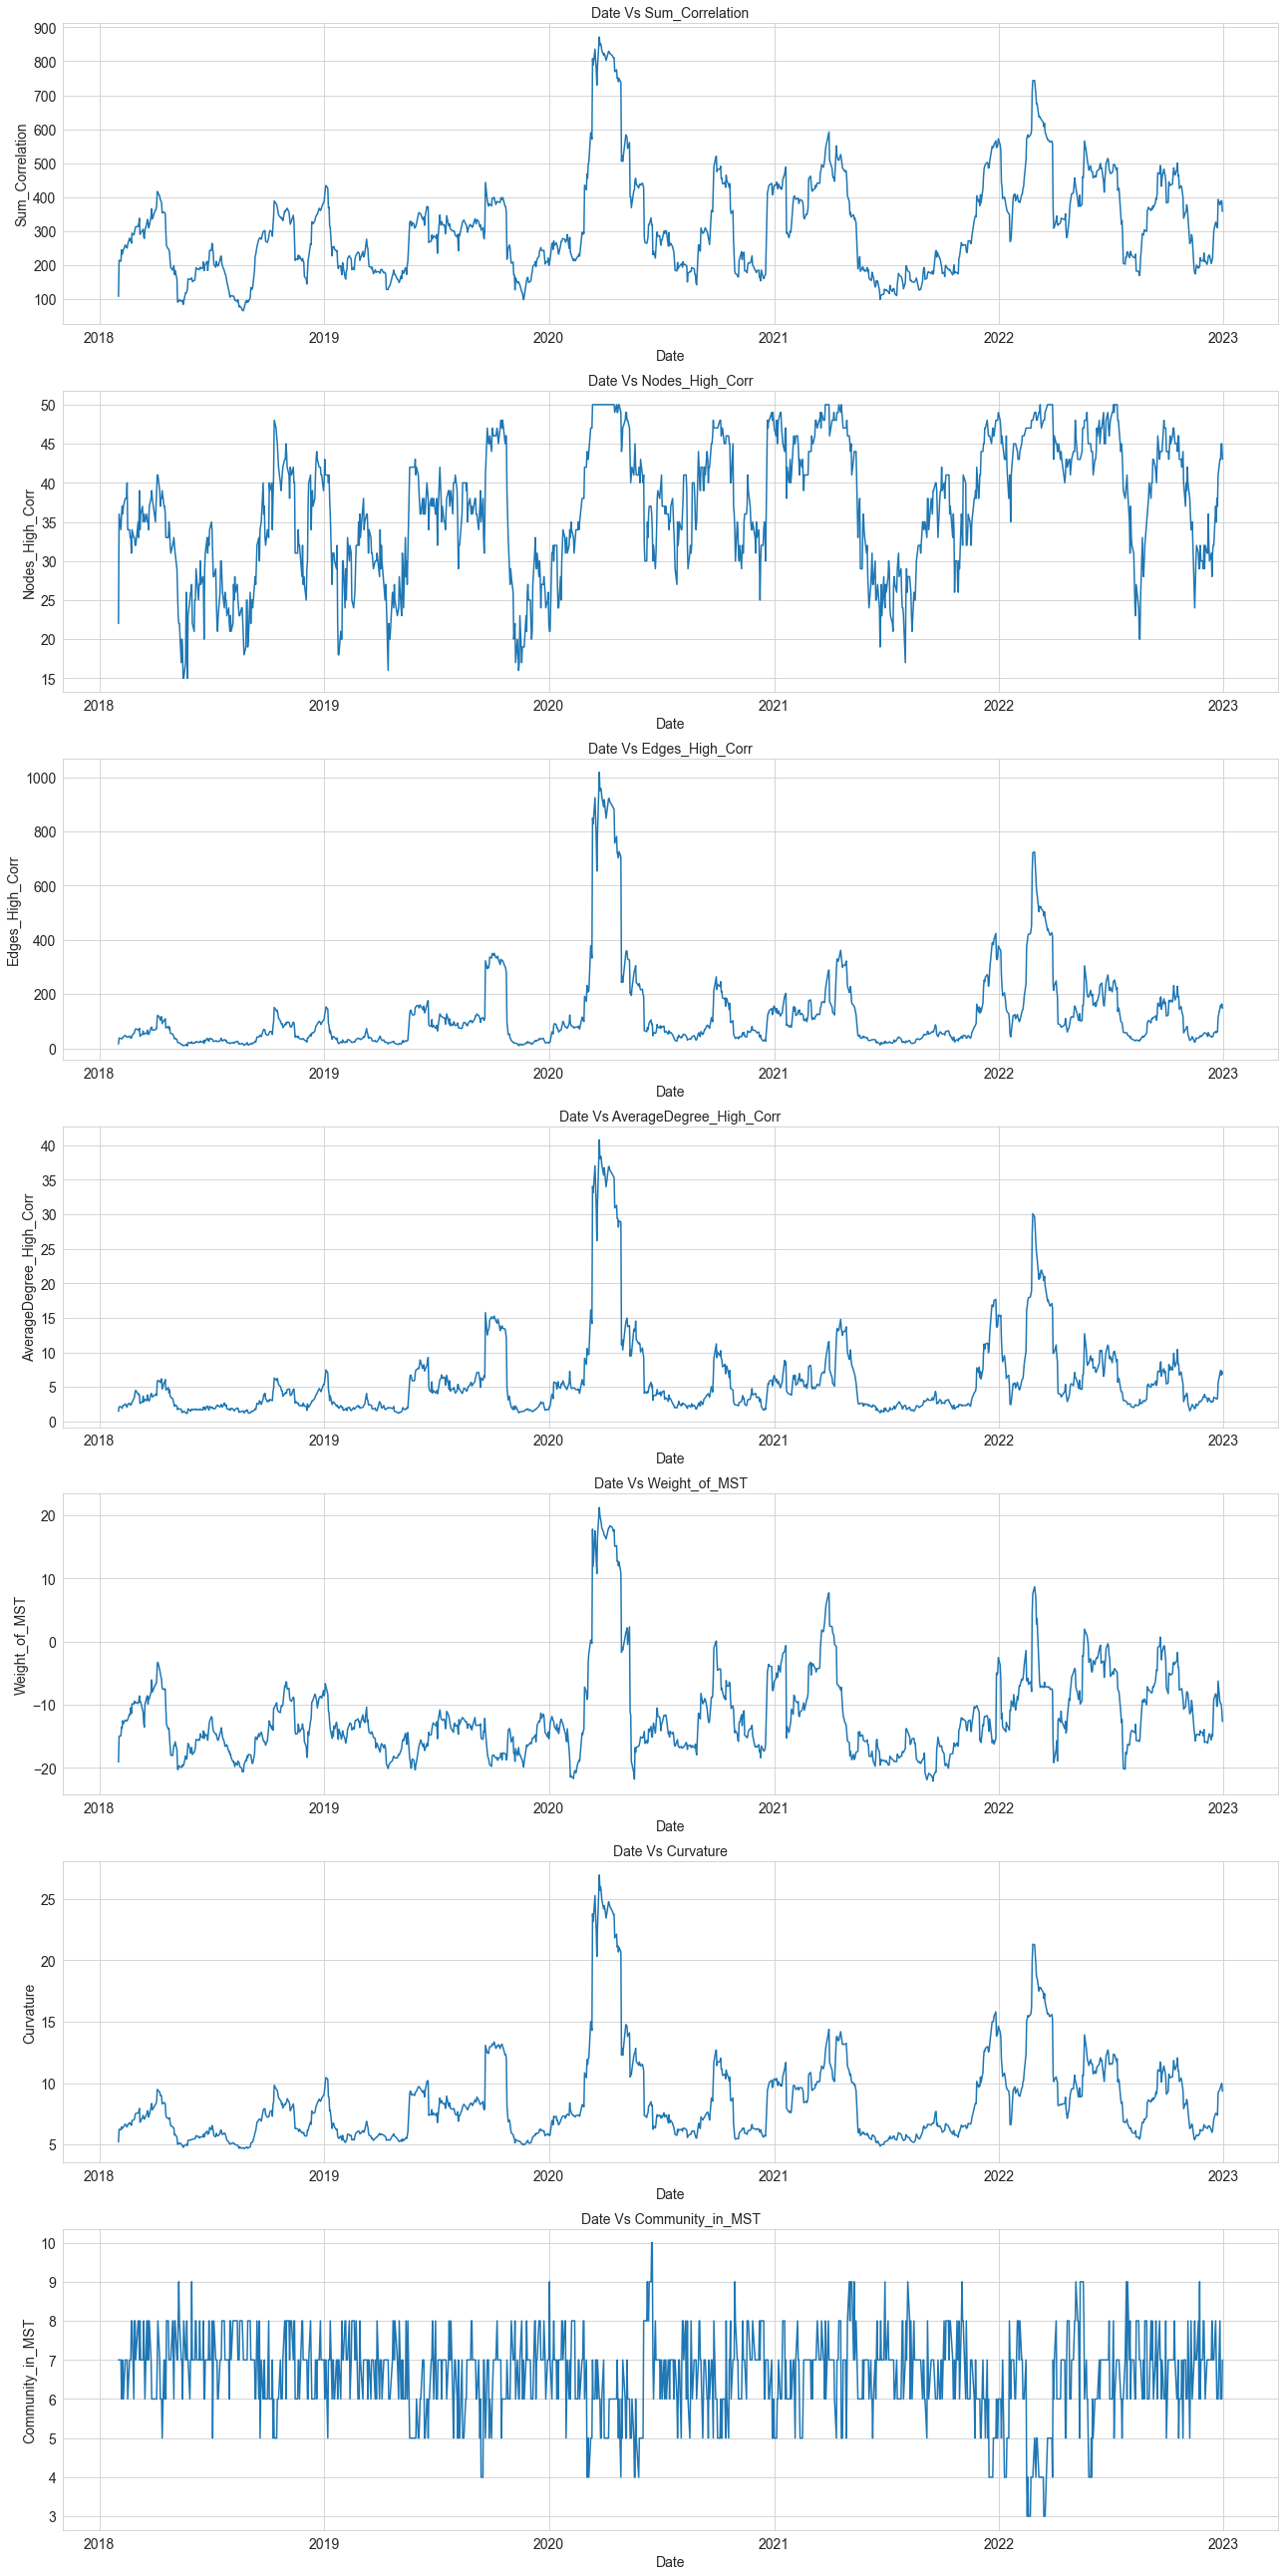

In [24]:
df=resultant_df.set_index("Date")
columns = df.columns
# Create subplots for each column with respect to "Date"
fig, axes = plt.subplots(len(columns), 1, figsize=(18, 36))

# Plot each column in its respective subplot
for i, column in enumerate(columns):
    ax = axes[i]
    ax.plot(df.index, df[column])
    ax.set_title(f"Date Vs {column}", fontsize=14)
    ax.set_ylabel(column, fontsize=14)
    ax.set_xlabel("Date", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()

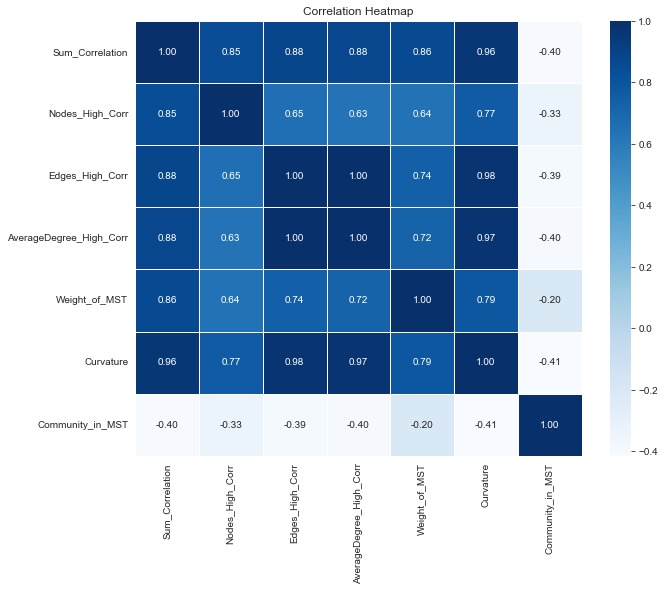

In [25]:
# Find correlation and create heatmap
m=resultant_df.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(m, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [26]:
# From the heatmap we see there is a tremendous correlation amoung the variabeles
# We now test these with INDIA VIX data

In [27]:
india_vix = pd.read_excel("India_VIX_Data.xlsx")
india_vix=india_vix[["Date", "Close"]]
india_vix=india_vix.rename(columns={"Close":"INDIA_VIX"})
india_vix

Date  INDIA_VIX
0    2018-02-01    14.1075
1    2018-02-02    15.2500
2    2018-02-05    16.0525
3    2018-02-06    20.0150
4    2018-02-07    19.4650
...         ...        ...
1205 2022-12-26    15.9325
1206 2022-12-27    15.2900
1207 2022-12-28    15.3950
1208 2022-12-29    14.8125
1209 2022-12-30    14.8675

[1210 rows x 2 columns]

In [28]:
resultant_df=resultant_df.merge(india_vix, on="Date", how="inner")
resultant_df

Date  Sum_Correlation  Nodes_High_Corr  Edges_High_Corr  \
0    2018-02-01           108.06               22               16   
1    2018-02-02           214.47               36               38   
2    2018-02-05           211.48               34               36   
3    2018-02-06           245.16               36               36   
4    2018-02-07           232.56               37               35   
...         ...              ...              ...              ...   
1205 2022-12-26           377.55               43              149   
1206 2022-12-27           385.37               43              159   
1207 2022-12-28           389.54               45              151   
1208 2022-12-29           389.25               45              164   
1209 2022-12-30           358.25               43              148   

      AverageDegree_High_Corr  Weight_of_MST  Curvature  Community_in_MST  \
0                        1.45         -19.10       5.20                 7   
1                        2.11         -15.01       6.23                 7   
2                        2.12         -14.95       6.18                 7   
3                        2.00         -13.53       6.42                 6   
4                        1.89         -13.71       6.29                 6   
...                       ...            ...        ...               ...   
1205                     6.93          -9.66       9.50                 8   
1206                     7.40          -9.73       9.70                 6   
1207                     6.71          -9.91       9.88                 6   
1208                     7.29         -10.87       9.98                 6   
1209                     6.88         -12.68       9.33                 7   

      INDIA_VIX  
0       14.1075  
1       15.2500  
2       16.0525  
3       20.0150  
4       19.4650  
...         ...  
1205    15.9325  
1206    15.2900  
1207    15.3950  
1208    14.8125  
1209    14.8675  

[1210 rows x 9 columns]

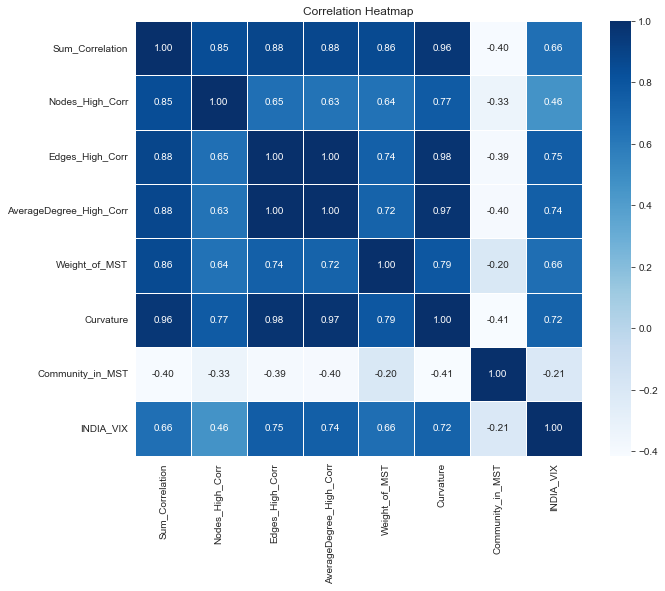

In [29]:
# Find correlation and create heatmap
m=resultant_df.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(m, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

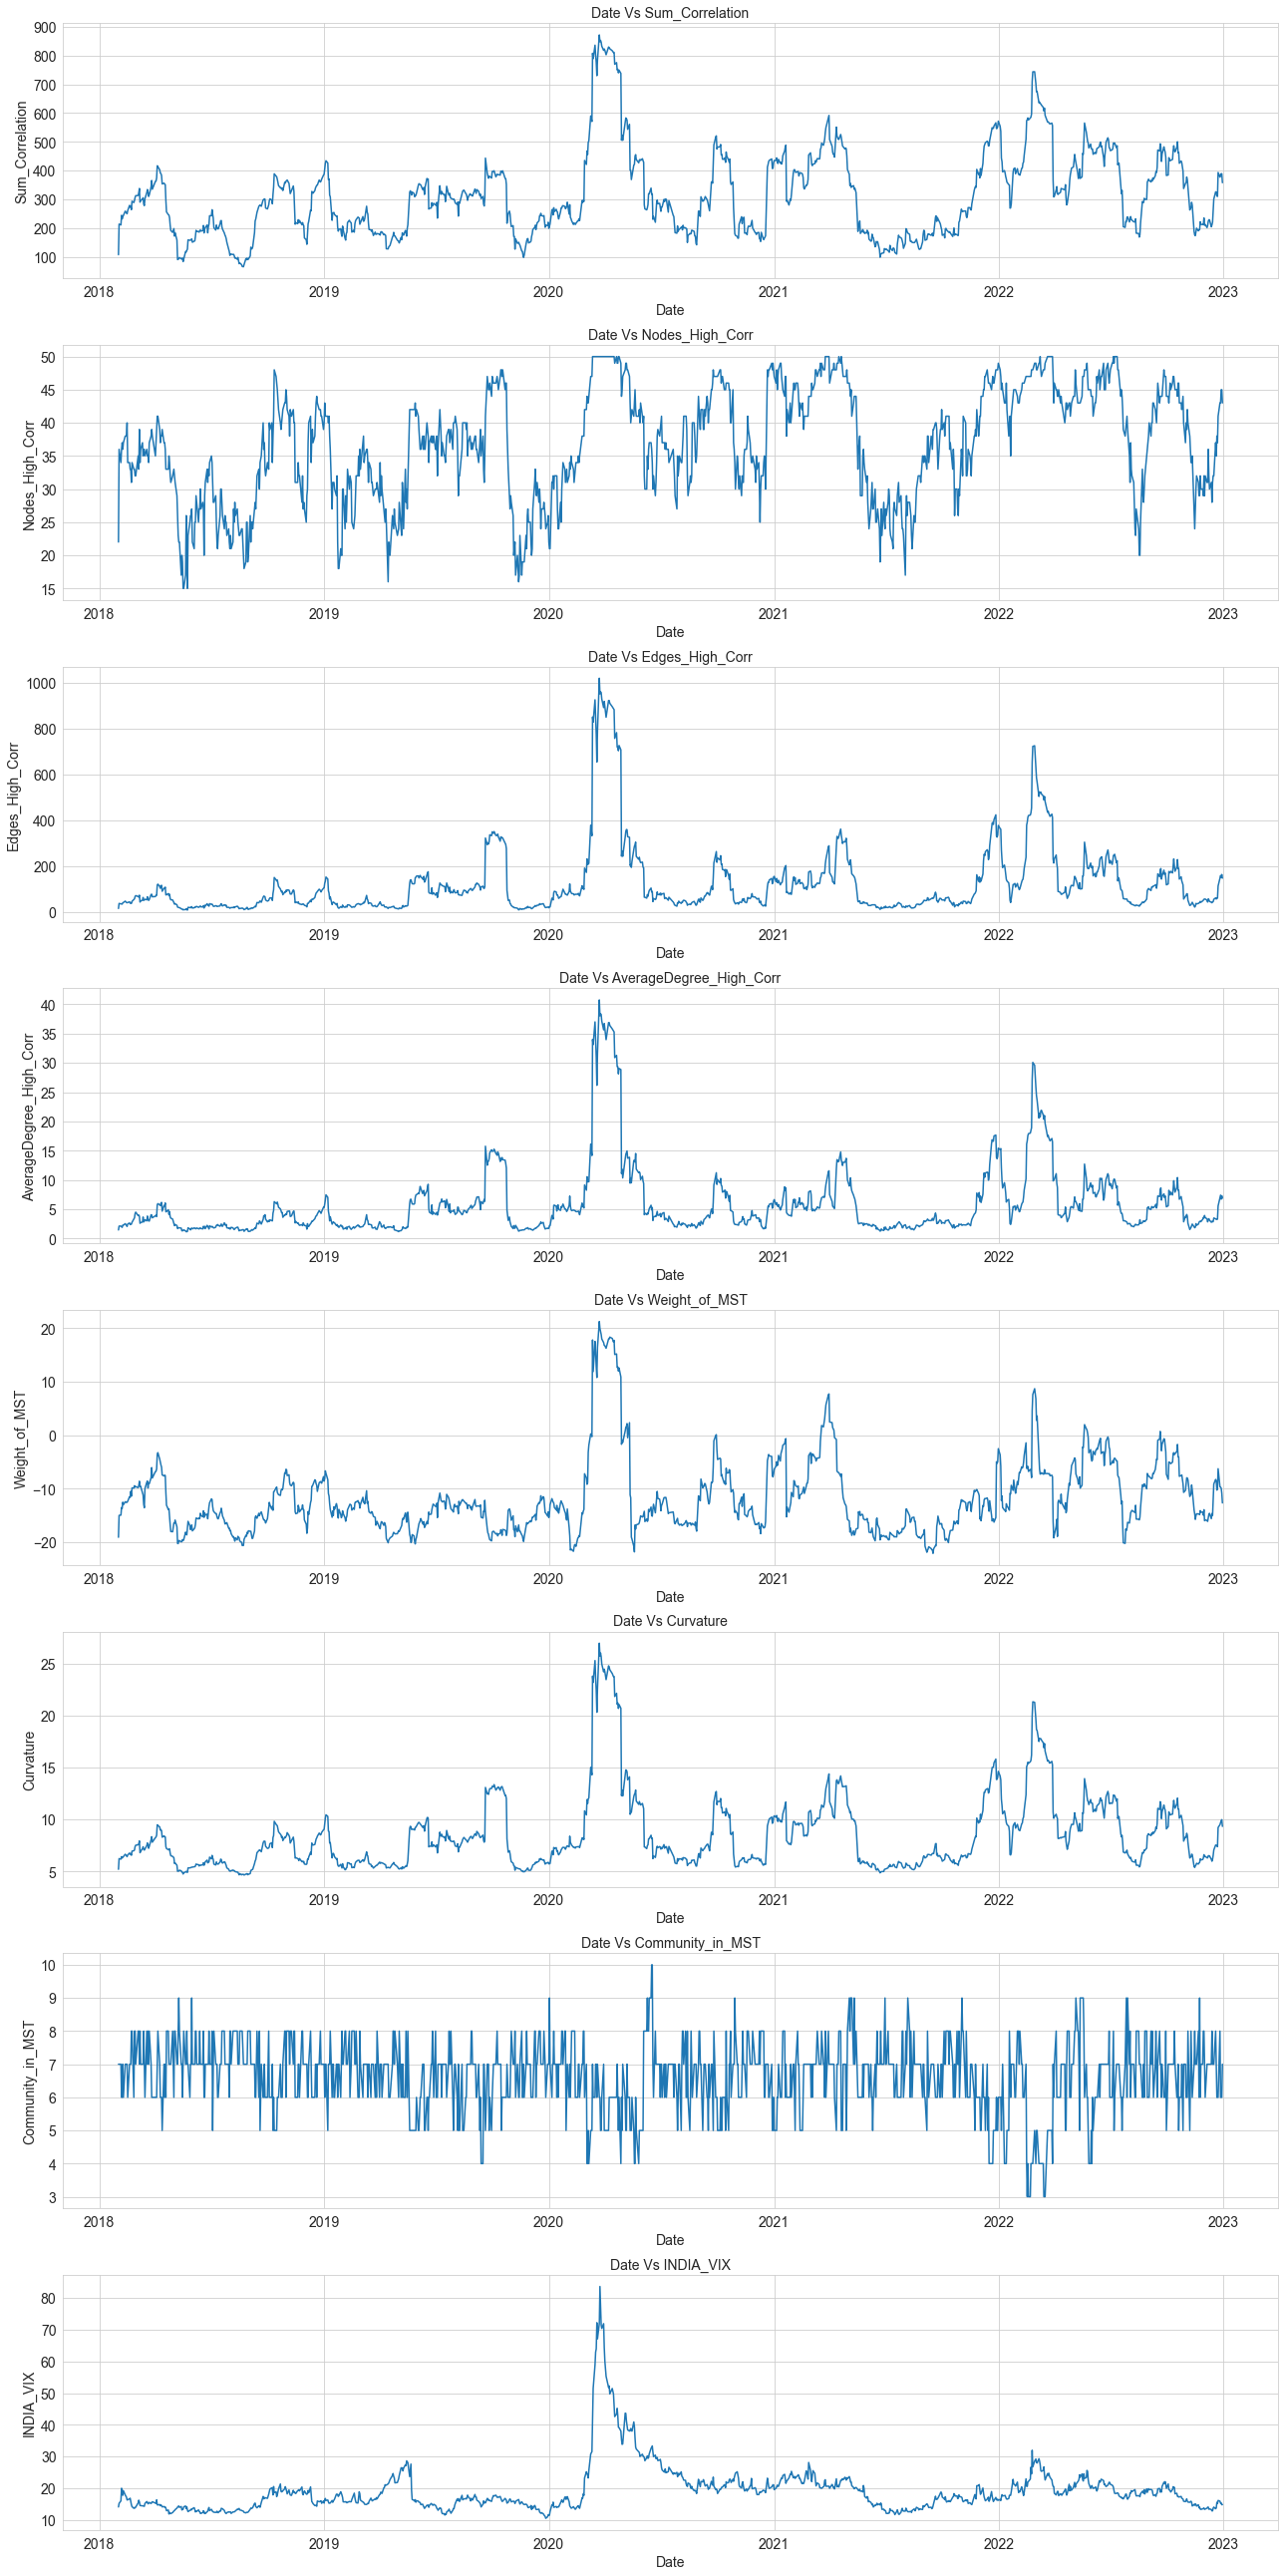

In [30]:
df=resultant_df.set_index("Date")
columns = df.columns
# Create subplots for each column with respect to "Date"
fig, axes = plt.subplots(len(columns), 1, figsize=(18, 36))

# Plot each column in its respective subplot
for i, column in enumerate(columns):
    ax = axes[i]
    ax.plot(df.index, df[column])
    ax.set_title(f"Date Vs {column}", fontsize=14)
    ax.set_ylabel(column, fontsize=14)
    ax.set_xlabel("Date", fontsize=14)
    ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()

### Future: 
1. Implementing ON TSX60 and S&P100
2. Train a model based on the findings and create a predictive indicator